In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage.io
import scipy.signal
import scipy.ndimage as ndimage
from jupyter_compare_view import compare
import warnings
from bm3d import rgb_to
from functools import partial
from pycsou.runtime import Precision, Width
import cupy as cp
from pycsou.util import get_array_module, to_NUMPY
from pycsou.runtime import enforce_precision
from pycsou.abc import LinOp
from pycsou.operator.interop import from_torch, from_sciop, from_source
import cupyx.scipy.signal
import scipy.signal
import torch
from pycsou.operator.interop.torch import *
from pycsou.abc import DiffMap, Map, DiffFunc, LinOp
from pycsou.operator import DiagonalOp, Stencil
from pycsou.operator import SquaredL2Norm
import time as t
import xdesign
import skimage
import skimage.transform as skt

warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "plasma"

rng = np.random.default_rng(seed=0)


def monochromatic(im, chan=0):
    out = im.copy()
    xp = get_array_module(im)
    mask = xp.ones(im.shape, dtype=bool)
    mask[chan] = False
    out[mask] = 0
    return out


def imshow(im, rgb=False):
    im = to_NUMPY(im)
    if im.ndim > 2 and rgb:
        plt.subplot(2, 2, 1)
        plt.imshow(np.moveaxis(im, 0, -1))
        plt.subplot(2, 2, 2)
        plt.imshow(np.moveaxis(monochromatic(im, 0), 0, -1))
        plt.subplot(2, 2, 3)
        plt.imshow(np.moveaxis(monochromatic(im, 1), 0, -1))
        plt.subplot(2, 2, 4)
        plt.imshow(np.moveaxis(monochromatic(im, 2), 0, -1))
    elif im.ndim > 2 and not rgb:
        plt.imshow(np.moveaxis(im, 0, -1))
    else:
        plt.imshow(im, cmap="plasma")
    plt.axis("off")


def imshow_compare(*images, **kwargs):
    images = [to_NUMPY(im) for im in images]
    images = [np.clip(im, 0, 1) for im in images]
    images = [np.moveaxis(im, 0, -1) if im.ndim > 2 else im for im in images]
    return compare(
        *images,
        cmap="plasma",
        height=700,
        add_controls=True,
        display_format="jpg",
        **kwargs
    )


warnings.filterwarnings("ignore")

<center> 
    
<img align="center" src="../doc/images/empa/first_page.jpg" alt="Welcome slide" width=100%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/g10575.png" alt="Forward model" width=60%>
</center>

<center> 
    
<img align="center" src="../doc/images/empa/recon_examples.jpg" alt="Forward model" width=90%>
</center>

<center>

<img align="center" src="../doc/images/empa/illposed.jpg" alt="Forward model" width=70%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/g15273.png" alt="Forward model" width=60%>
</center>

<center>

<img align="center" src="../doc/images/empa/g15005.png" alt="Forward model" width=60%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/Natural Images Manifold (5).jpg" alt="Forward model" width=95%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/l2_l1.jpg" alt="Forward model" width=90%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/nerf_dark.gif" alt="Forward model" width=70%>
</center>

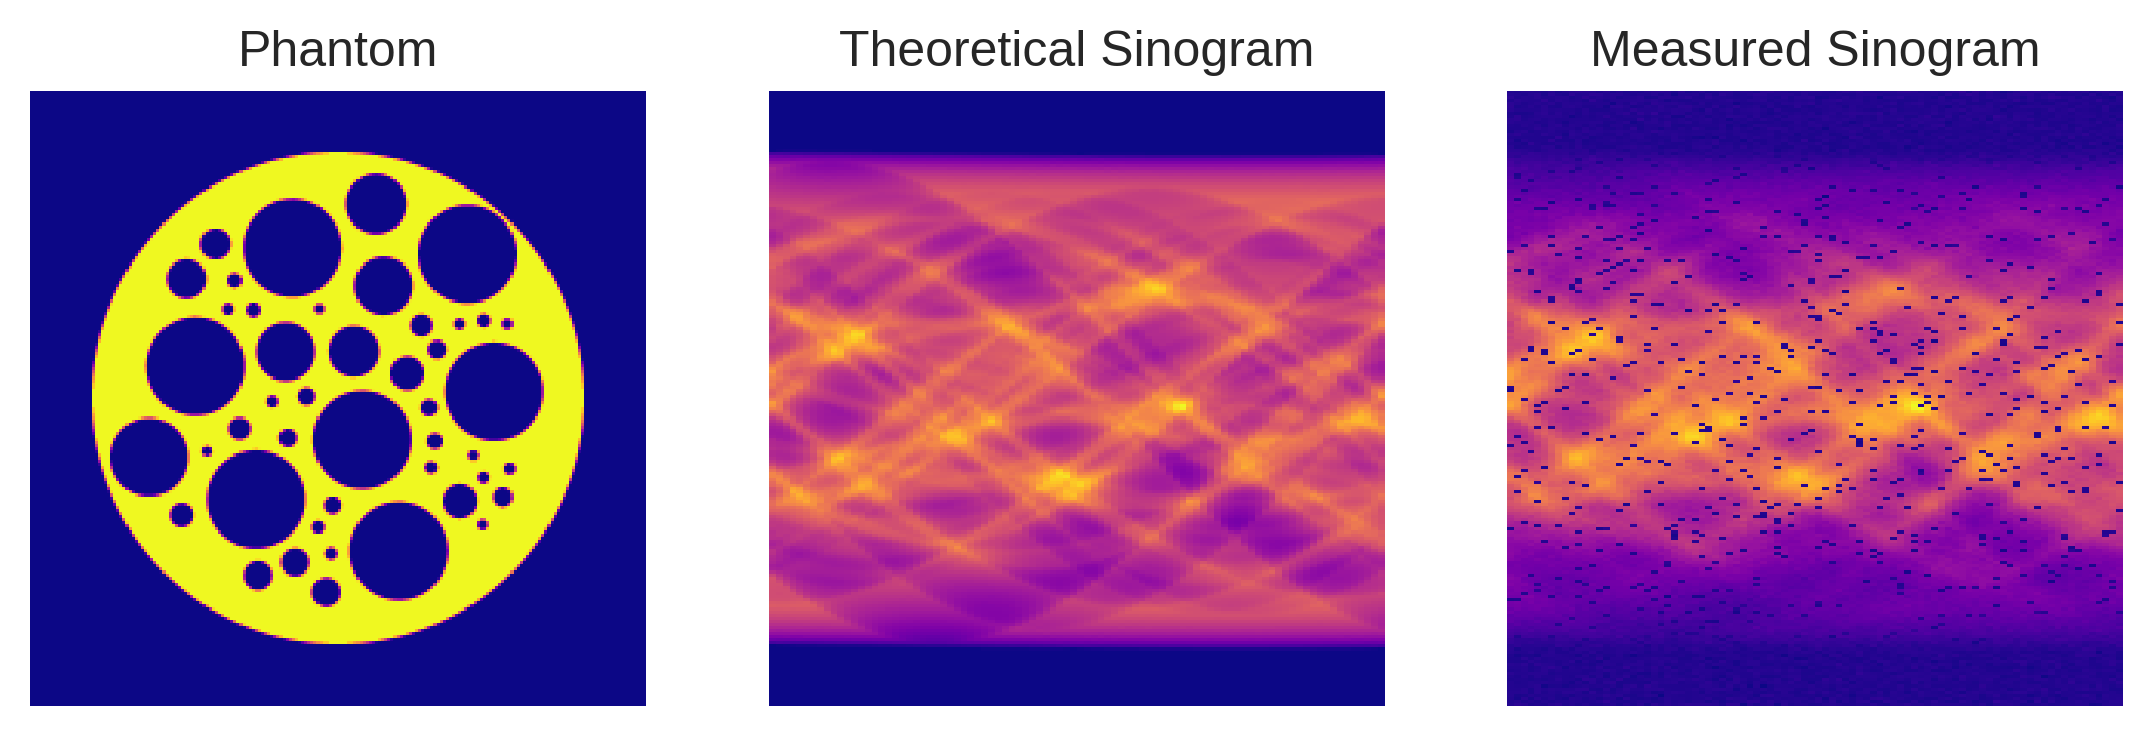

In [3]:
# Generate phantom
np.random.seed(0)
p1 = xdesign.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
phantom = xdesign.discrete_phantom(p1, 160) * 10
phantom = np.abs(np.pad(phantom, 20))

# Generate sinogram 
rng = np.random.default_rng(0)
psnr = 20 # 10 * log(s/n) = psnr => n = s * 10^(-psnr/10)
angles, wsize = 90, 5
sino0 = skt.radon(phantom, theta=np.linspace(0, 180, angles), circle=True)
sino = ndimage.uniform_filter(sino0, [wsize, 0], mode='constant')
mask = rng.binomial(1, 0.95, sino.shape)
#mask = np.ones_like(sino)
#mask[50:75, 5:25] = 0.3
#mask[100:150, 40:60] = 0.4
#mask[0:75, 80:85] = 0.2
#mask[150:175, 70:80] = 0.6
sino *= mask
sino *= scipy.signal.get_window('hamming', sino.shape[0])[:, None]
sigma = np.abs(sino).max() * (10**(-psnr/10))
sino += rng.normal(scale=sigma, size=sino.shape)

_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title("Phantom")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(sino0, aspect=0.45)
_ = plt.title("Theoretical Sinogram")
_ = plt.axis('off')


_ = plt.subplot(1,3,3)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')


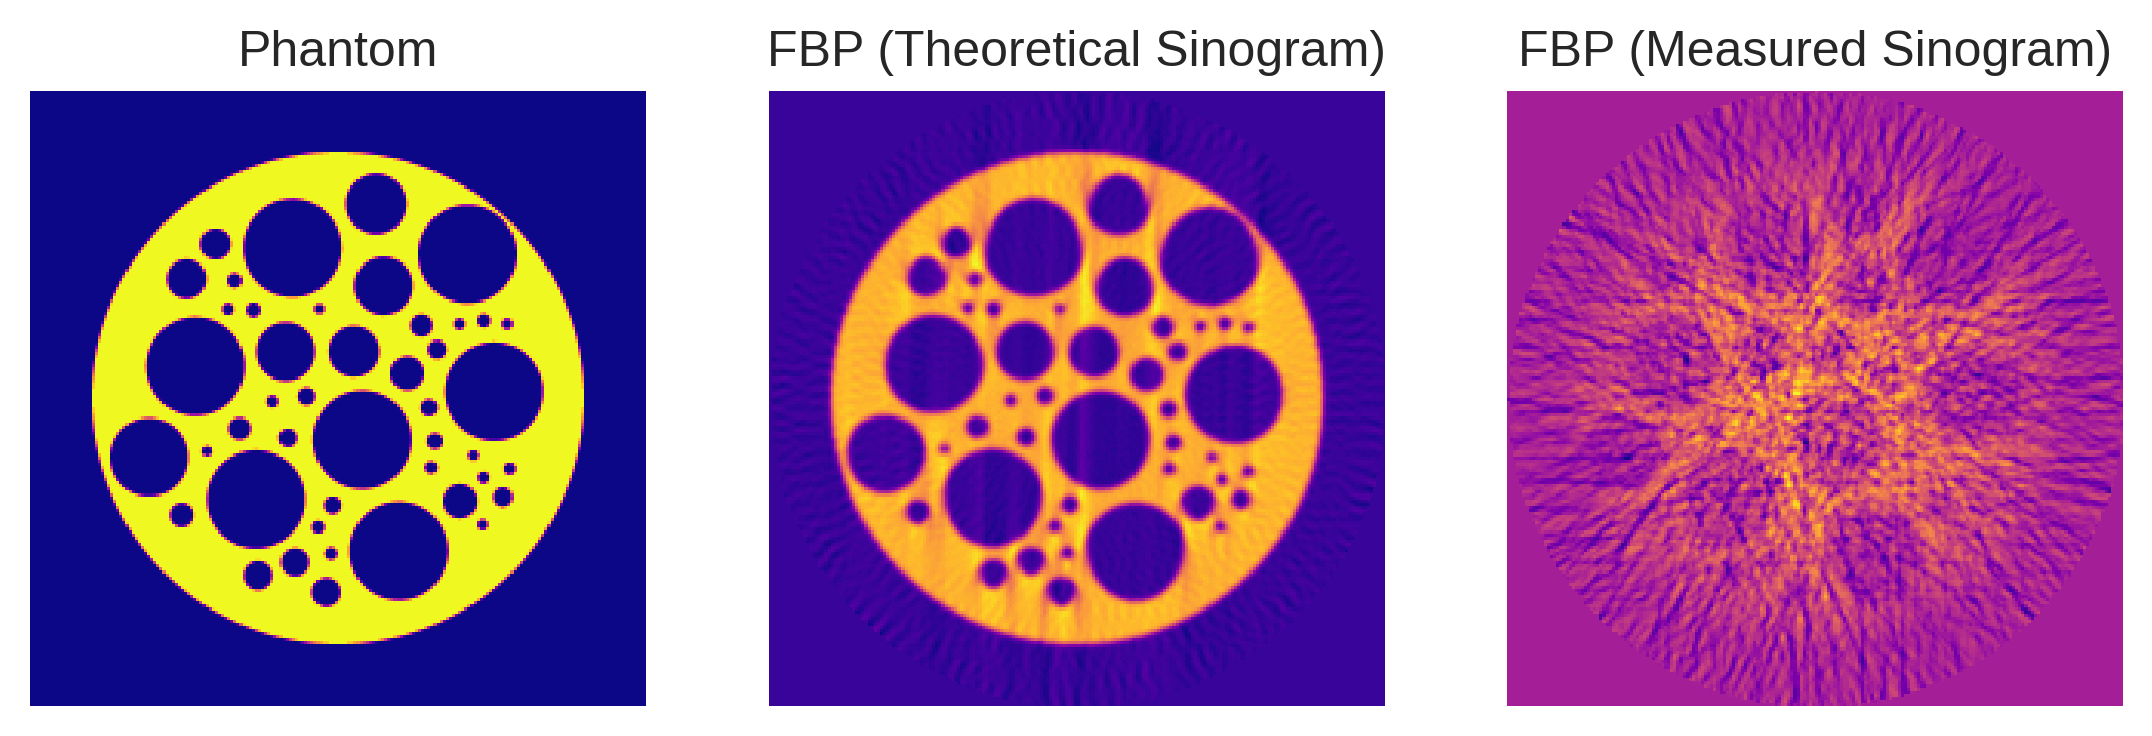

In [4]:
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino0, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Theoretical Sinogram)')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Measured Sinogram)')
_ = plt.axis('off')

### Huge performance drop! How can we fix that?

<center>
    
<img align="center" src="../doc/images/empa/modular.png" alt="Forward model" width=85%>
</center>

<center>
    
<img align="center" src="../doc/images/empa/pycsou.jpg" alt="Forward model" width=100%>
</center>

## Model of the Tomographic Setup

$$\Phi= T \circ M \circ F \circ R$$

In [5]:
# Radon Operator
Radon = from_source(cls=LinOp,
                    shape=(sino.size, phantom.size),
                    apply=lambda self, arr: skt.radon(arr.reshape(phantom.shape), 
                                                      theta=np.linspace(0, 180, angles), 
                                                      circle=True).ravel(),
                    adjoint=lambda self, arr: skt.iradon(arr.reshape(sino.shape), 
                                                         filter_name=None, 
                                                         circle=True).ravel(),
                    vectorize=["apply", "adjoint"], vmethod="scan", enforce_precision=["apply", "adjoint"])

# 1D Filtering
boxcar = np.asarray(scipy.signal.get_window("boxcar", wsize)); boxcar /= wsize
BoxCar1D = Stencil(kernel=[boxcar, np.array([1.0])], center=(wsize // 2, 0), arg_shape=sino.shape,)

# Partial Masking
Mask = DiagonalOp(mask.ravel())

# Tapering
taper = np.outer(scipy.signal.get_window("hamming", sino.shape[0]), np.ones(sino.shape[1]))
Taper = DiagonalOp(taper.ravel())

# Compose operators
Phi = Taper * Mask * BoxCar1D * Radon
print(Phi.expr())

[compose, ==> LinOp(18000, 40000)
.[compose, ==> SquareOp(18000, 18000)
..[compose, ==> SquareOp(18000, 18000)
...DiagonalOp(18000, 18000),
...DiagonalOp(18000, 18000)],
..Stencil(18000, 18000)],
.LinOp(18000, 40000)]


In [6]:
predicted_sino = Phi(phantom.ravel()).reshape(sino.shape)

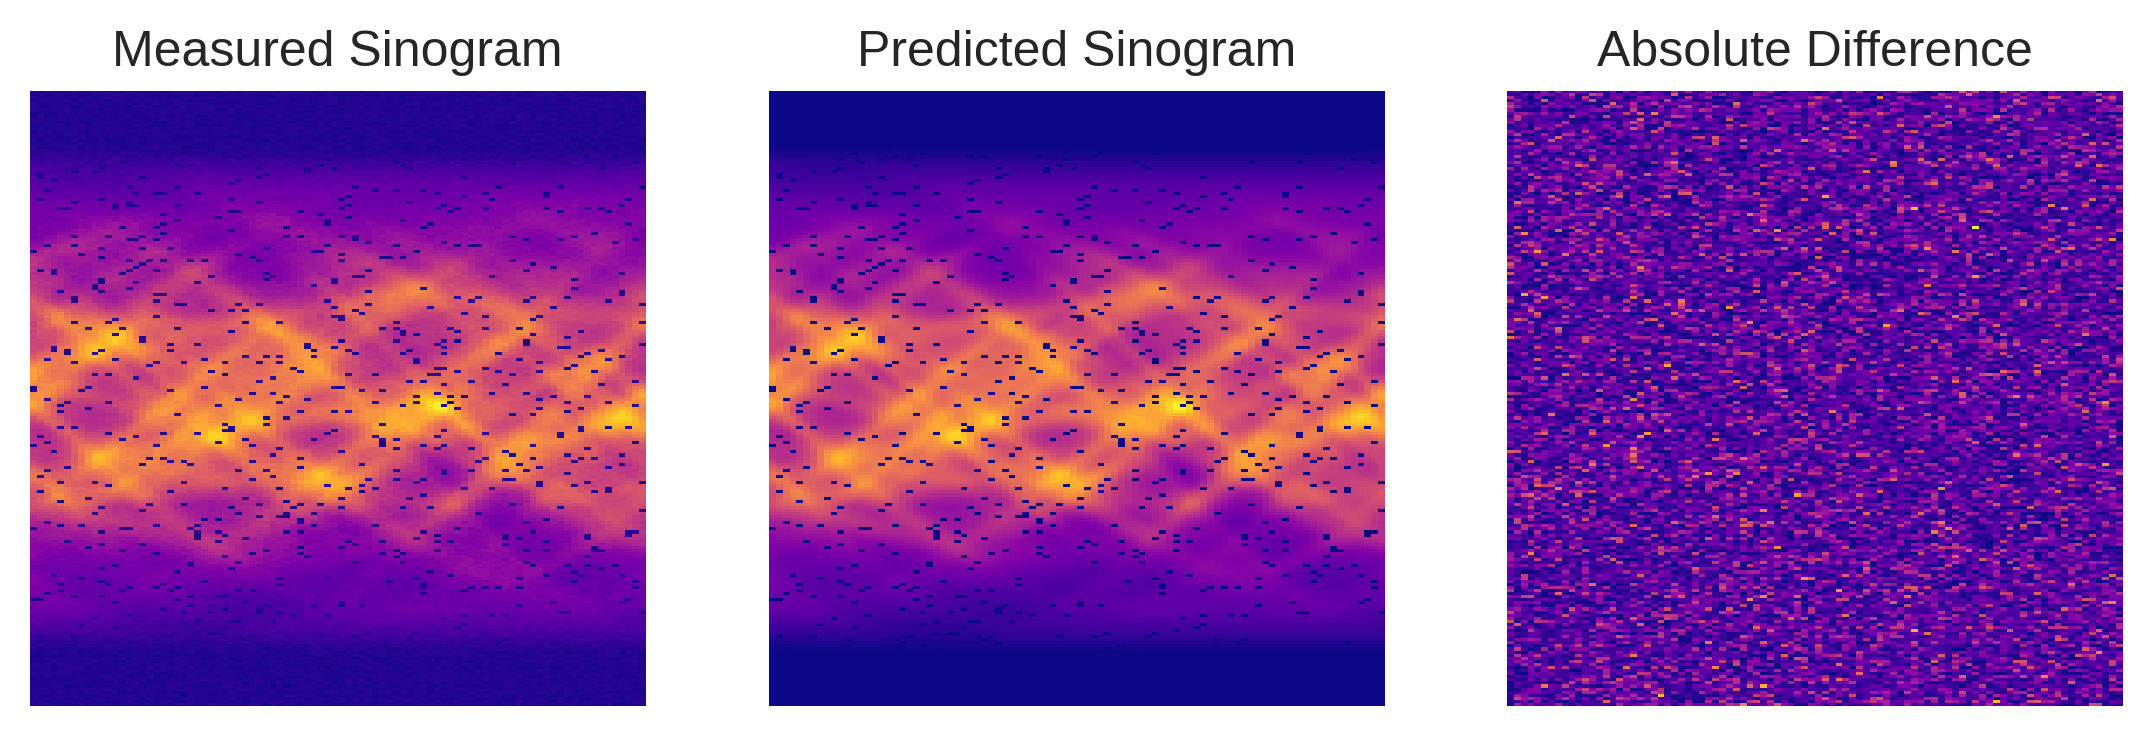

In [7]:
_ = plt.subplot(1,3,1)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(predicted_sino, aspect=0.45)
_ = plt.title("Predicted Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,3)
_ = plt.imshow(np.abs(sino-predicted_sino), aspect=0.45)
_ = plt.title("Absolute Difference")
_ = plt.axis('off')

<center>
    
<img align="center" src="../doc/images/empa/g15273.png" alt="Forward model" width=60%>
</center>

In [8]:
from pycsou.opt.stop import RelError, MaxIter

default_stop_crit = RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | MaxIter(500)
pinv_solution = Phi.pinv(sino.ravel(), damp=4,  
                         kwargs_init=dict(show_progress=False, verbosity=50),
                         kwargs_fit=dict(stop_crit=default_stop_crit))

INFO:/tmp/pycsou_48wcxyvd:[2023-05-14 17:56:12.464330] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_48wcxyvd:[2023-05-14 17:56:13.425873] Iteration 18
	iteration: 18
	RelError[x]: 0.0008930069037400444
	N_iter: 19.0
INFO:/tmp/pycsou_48wcxyvd:[2023-05-14 17:56:13.426648] Stopping Criterion satisfied -> END


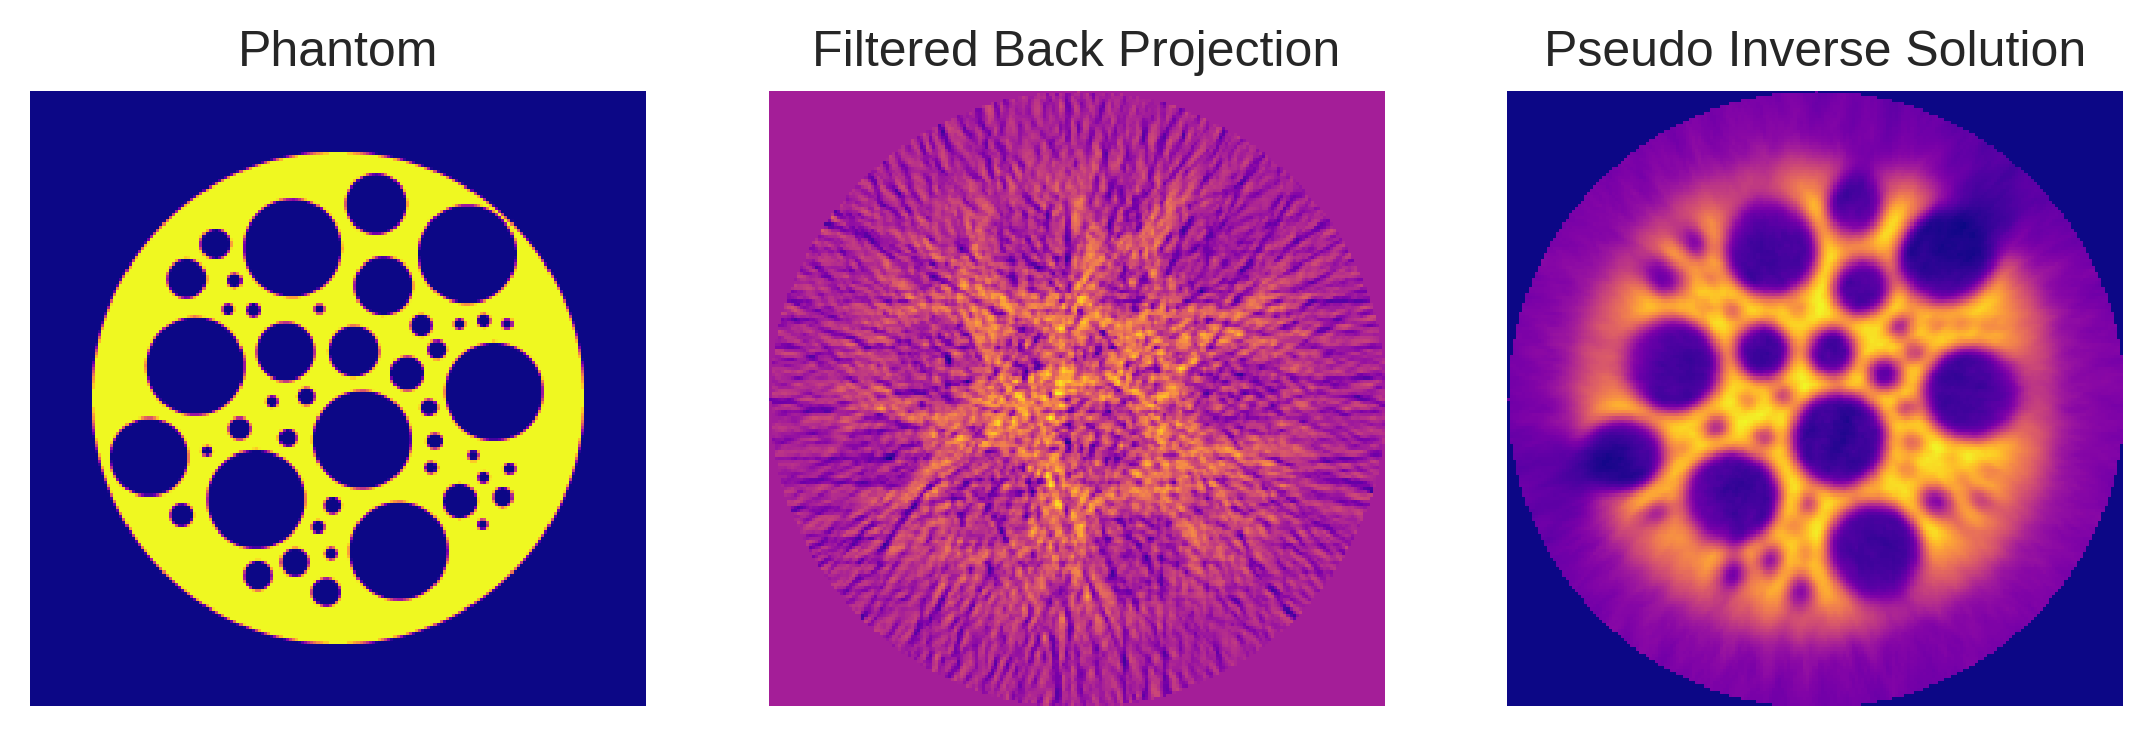

In [9]:
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')

<center>

<img align="center" src="../doc/images/empa/g15005.png" alt="Forward model" width=60%>
</center>

### Bayesian Model

We consider a least-squares loss and a TV prior with positivity constraint. 

$$\hat{f}\in \arg\min_{f\geq 0} \frac{1}{2\sigma^2}\|g - \Phi(f)\|_2^2 +  \lambda\|\nabla f\|_{1} + \mu \|f\|_1$$

In [20]:
from pycsou.operator import Gradient, SquaredL2Norm, L1Norm, PositiveOrthant, PositiveL1Norm

# TV prior
grad = Gradient(arg_shape=phantom.shape, accuracy=4, mode='constant', diff_method='fd')
lambda_= 0.05 / (2 * sigma**2)
huber_norm = L1Norm().moreau_envelope(0.01)
tv_prior = lambda_ * huber_norm * grad

# Positivity + L1 norm 
posL1 = 0.05 * PositiveL1Norm(phantom.size)

# Loss
loss = (1/ (2 * sigma**2)) * SquaredL2Norm(dim=sino.size).asloss(sino.ravel()) * Phi

# Posterior
posterior = loss + tv_prior
beta = posterior.diff_lipschitz(tight=True, tol=0.1)

In [21]:
from pycsou.opt.solver import PGD

solver = PGD(f=posterior, g=posL1, show_progress=False, verbosity=250)
solver.fit(x0=0*pinv_solution.ravel(), tau=1/beta, acceleration=True, stop_crit=default_stop_crit)
recon_tv = solver.solution().squeeze()

INFO:/tmp/pycsou_t1meg0j_:[2023-05-14 18:02:39.066481] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO:/tmp/pycsou_t1meg0j_:[2023-05-14 18:02:51.548070] Iteration 250
	iteration: 250
	RelError[x]: 0.0015145020479656864
	N_iter: 251.0
INFO:/tmp/pycsou_t1meg0j_:[2023-05-14 18:02:55.089035] Iteration 320
	iteration: 320
	RelError[x]: 0.0009948083696310445
	N_iter: 321.0
INFO:/tmp/pycsou_t1meg0j_:[2023-05-14 18:02:55.089595] Stopping Criterion satisfied -> END


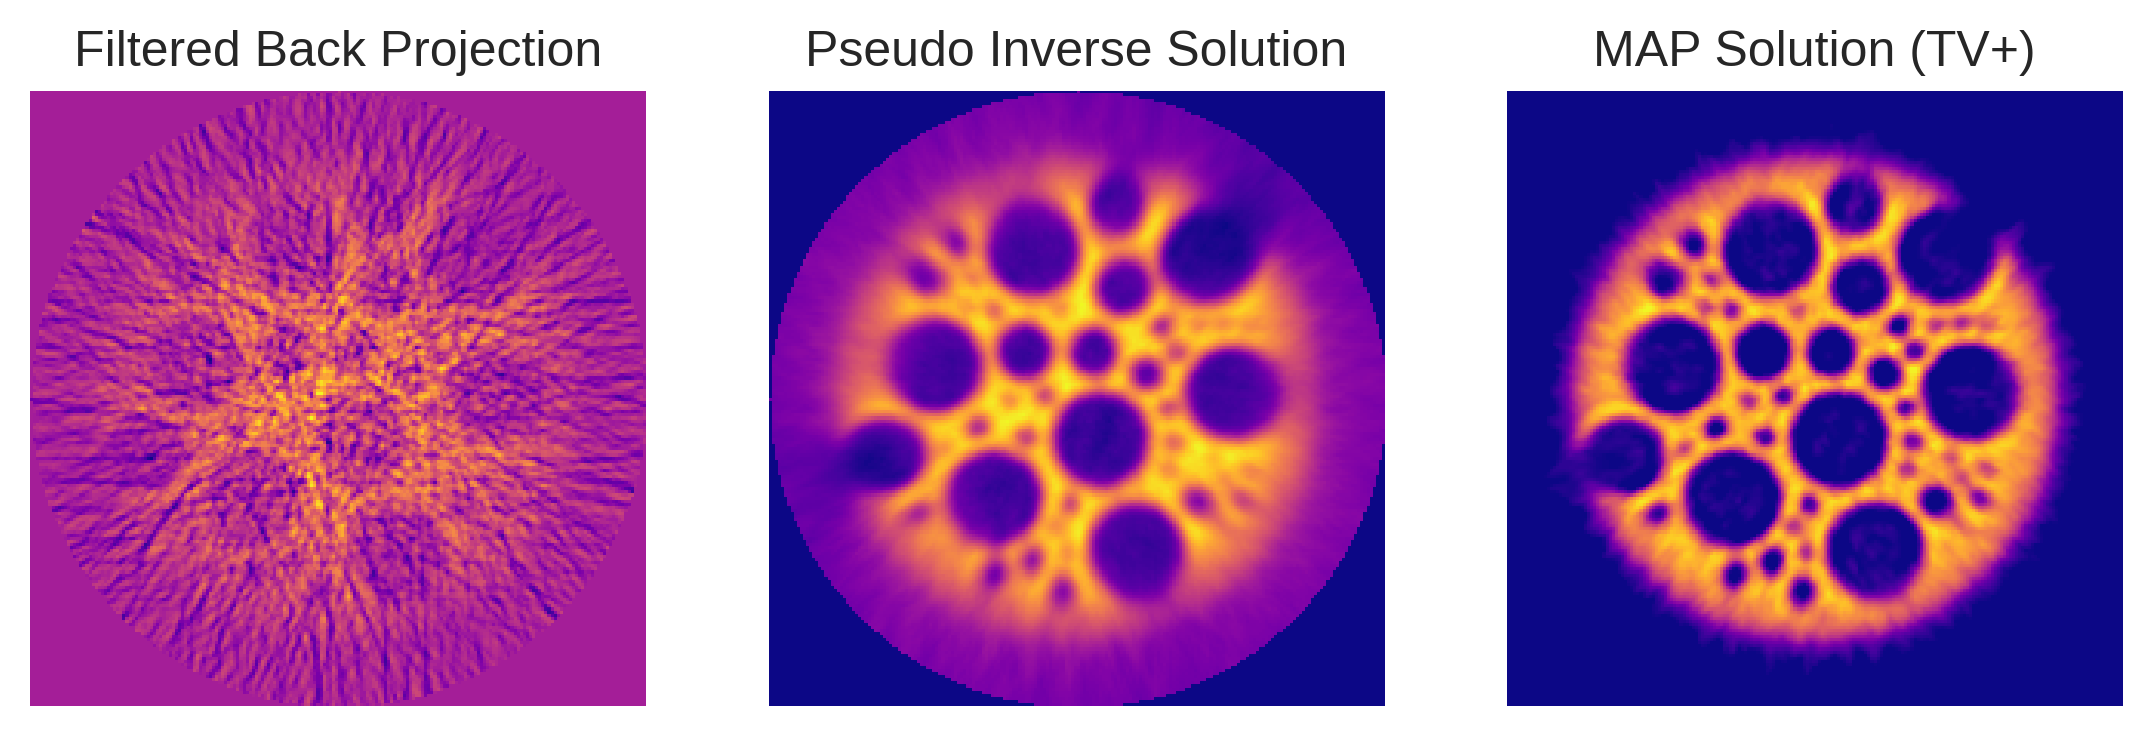

In [22]:
_ = plt.subplot(1,3,1)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(recon_tv.reshape(phantom.shape))
_ = plt.title('MAP Solution (TV+)')
_ = plt.axis('off')

In [47]:
from pycsou.sampler.sampler import ULA
import pycsou.sampler.statistics as pycstat

f = (2 * sigma ** 2) * (loss + tv_prior + posL1.moreau_envelope(0.01))
gamma = 0.25 / (2 * sigma ** 2)  # ULA sampler
n = int(1000)  # Number of samples
burn_in = int(100)  # Number of burn-in iterations
sample = 0 * pinv_solution.ravel()  # Generator for ULA samples
# Objects for computing online statistics based on samples
online_mean = pycstat.OnlineMoment(order=1)
online_var = pycstat.OnlineVariance()
# Draw samples
for i in range(n):  # Burn-in phase
    if i > burn_in:
        sample = sample - gamma * f.grad(sample) + np.sqrt(2 * gamma) * rng.standard_normal(size=phantom.size)
        mean = online_mean.update(sample)  # Update online mean
        var = online_var.update(sample)  # Update online variance

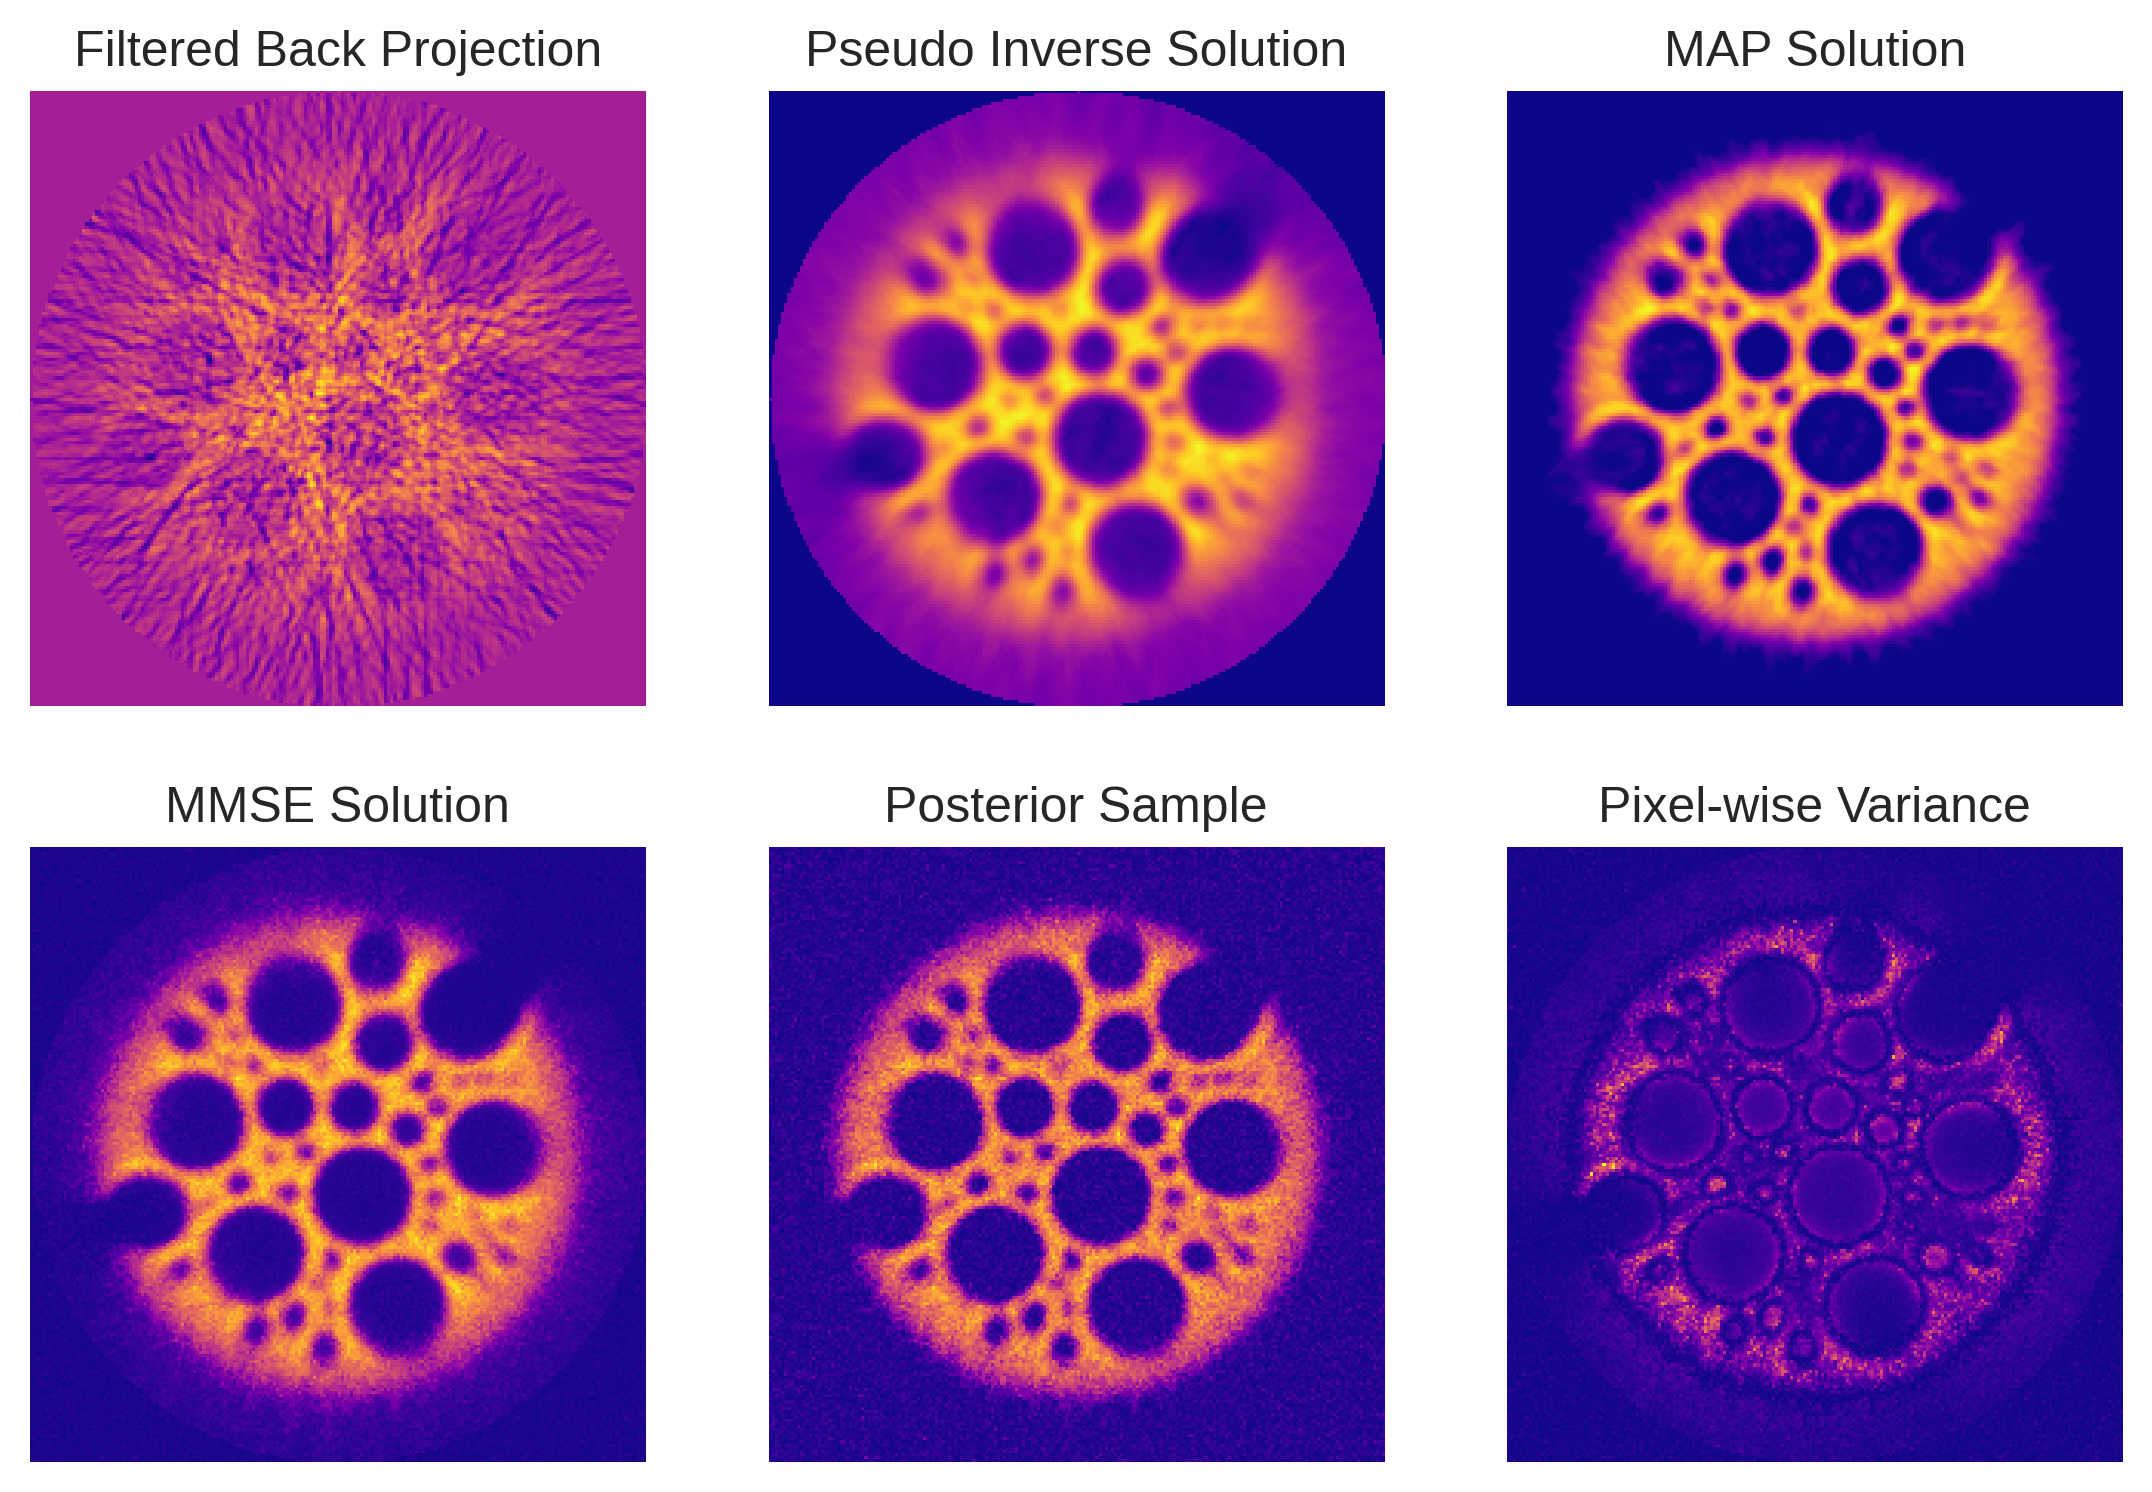

In [48]:
_ = plt.subplot(2,3,1)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(2,3,2)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')
_ = plt.subplot(2,3,3)
_ = plt.imshow(recon_tv.reshape(phantom.shape))
_ = plt.title('MAP Solution')
_ = plt.axis('off')
_ = plt.subplot(2,3,4)
_ = plt.imshow(mean.reshape(phantom.shape))
_ = plt.title('MMSE Solution')
_ = plt.axis('off')
_ = plt.subplot(2,3,5)
_ = plt.imshow(sample.reshape(phantom.shape))
_ = plt.title('Posterior Sample')
_ = plt.axis('off')
_ = plt.subplot(2,3,6)
_ = plt.imshow(var.reshape(phantom.shape))
_ = plt.title('Pixel-wise Variance')
_ = plt.axis('off')